In [1]:
!pip install fiftyone
!pip install fiftyone-db-ubuntu2204

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from torchvision.transforms import functional as F

In [3]:
custom_dataset_dir = "/kaggle/working/dataset"
fo.config.dataset_zoo_dir = custom_dataset_dir

try:
    train_dataset = foz.load_zoo_dataset(
        "coco-2017",
        split="train",
        label_types=["detections", "segmentations"], 
        classes=["person"],  
        max_samples=3000, 
        dataset_name="coco-2017-train-persons", 
    )
    print("Train dataset loaded successfully!")
except Exception as e:
    print(f"Error loading train dataset: {e}")

try:
    val_dataset = foz.load_zoo_dataset(
        "coco-2017",
        split="validation",
        label_types=["detections", "segmentations"],
        classes=["person"],
        max_samples=750,
        dataset_name="coco-2017-validation-persons",
    )
    print("Validation dataset loaded successfully!")
except Exception as e:
    print(f"Error loading validation dataset: {e}")

Found annotations at '/kaggle/working/dataset/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading 'coco-2017' split 'train'
 100% |███████████████| 3000/3000 [1.1m elapsed, 0s remaining, 48.9 samples/s]      
Dataset 'coco-2017-train-persons' created
Train dataset loaded successfully!
Found annotations at '/kaggle/working/dataset/coco-2017/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 750/750 [16.4s elapsed, 0s remaining, 43.2 samples/s]      
Dataset 'coco-2017-validation-persons' created
Validation dataset loaded successfully!


In [4]:
if len(train_dataset) == 0:
    print("Dataset is empty. Please check the dataset or filters.")
else:
    print(f"Dataset contains {len(train_dataset)} samples.")

if len(val_dataset) == 0:
    print("Dataset is empty. Please check the dataset or filters.")
else:
    print(f"Dataset contains {len(val_dataset)} samples.")

Dataset contains 3000 samples.
Dataset contains 750 samples.


In [5]:
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        self.imgs_dir = imgs_dir
        self.available_images = set(os.listdir(imgs_dir))  
        
        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.filename_to_id = {img['file_name']: img['id'] for img in coco['images']}

        self.annIm_dict = defaultdict(list)
        for ann in coco['annotations']:
            if ann['category_id'] == 1:  # Person
                self.annIm_dict[ann['image_id']].append(ann)

        self.cat_dict = {cat['id']: cat for cat in coco['categories']}
    
    def get_available_image_ids(self):
        available_ids = []
        for filename in self.available_images:
            if filename in self.filename_to_id:
                available_ids.append(self.filename_to_id[filename])
        return available_ids
    
    def load_img(self, img_id):
        for filename, current_id in self.filename_to_id.items():
            if current_id == img_id:
                img_path = os.path.join(self.imgs_dir, filename)
                if os.path.exists(img_path):
                    return Image.open(img_path).convert("RGB")
        return None

class COCODataset(Dataset):
    def __init__(self, coco_parser, transforms=None):
        self.coco_parser = coco_parser
        self.transforms = transforms
        self.image_ids = coco_parser.get_available_image_ids()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img = self.coco_parser.load_img(img_id)
        annotations = self.coco_parser.annIm_dict[img_id]

        boxes = []
        labels = []
        
        for ann in annotations:

            bbox = ann['bbox']
            x, y, w, h = bbox
            boxes.append([x, y, x + w, y + h])  

            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
        }

        if self.transforms:
            img, target = self.transforms(img, target)
        
        return img, target

In [6]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

class Resize:
    def __init__(self, size):
        self.size = size 

    def __call__(self, image, target):

        if not isinstance(image, Image.Image):
            raise TypeError("Resize harus diterapkan sebelum ToTensor!")
        
        original_size = image.size 
        image = F.resize(image, self.size)

        ratio_width = self.size[0] / original_size[0]  
        ratio_height = self.size[1] / original_size[1]  

        target["boxes"][:, [0, 2]] *= ratio_width
        target["boxes"][:, [1, 3]] *= ratio_height
        
        return image, target

def get_transform(train):
    transforms = []
    transforms.append(Resize((224, 224)))  
    transforms.append(ToTensor())         
    transforms.append(Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return Compose(transforms)

In [7]:
coco_annotations_file_train = "/kaggle/working/dataset/coco-2017/raw/instances_train2017.json"
coco_images_dir_train = "/kaggle/working/dataset/coco-2017/train/data"
coco_annotations_file_val = "/kaggle/working/dataset/coco-2017/raw/instances_val2017.json"
coco_images_dir_val = "/kaggle/working/dataset/coco-2017/validation/data"

coco_parser_train = COCOParser(coco_annotations_file_train, coco_images_dir_train)
coco_parser_val = COCOParser(coco_annotations_file_val, coco_images_dir_val)

train_dataset = COCODataset(coco_parser_train, transforms=get_transform(train=True))
val_dataset = COCODataset(coco_parser_val, transforms=get_transform(train=False))

train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

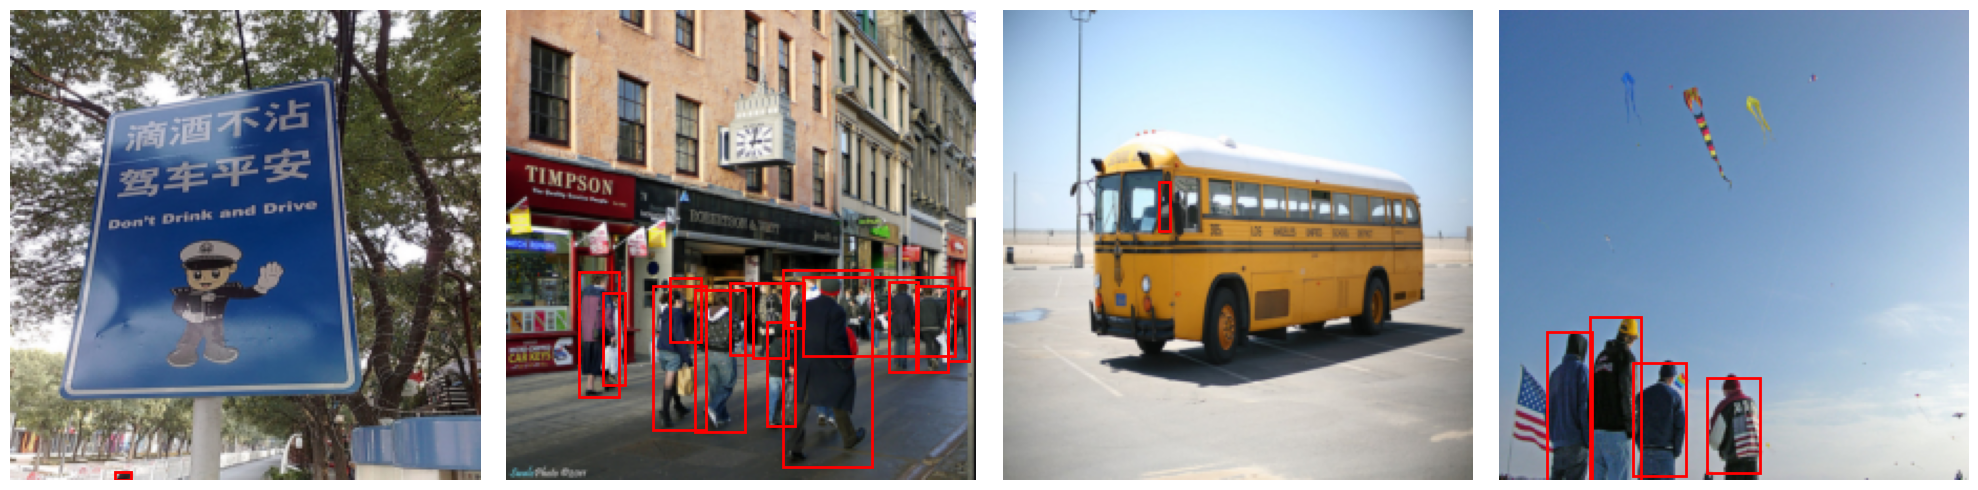

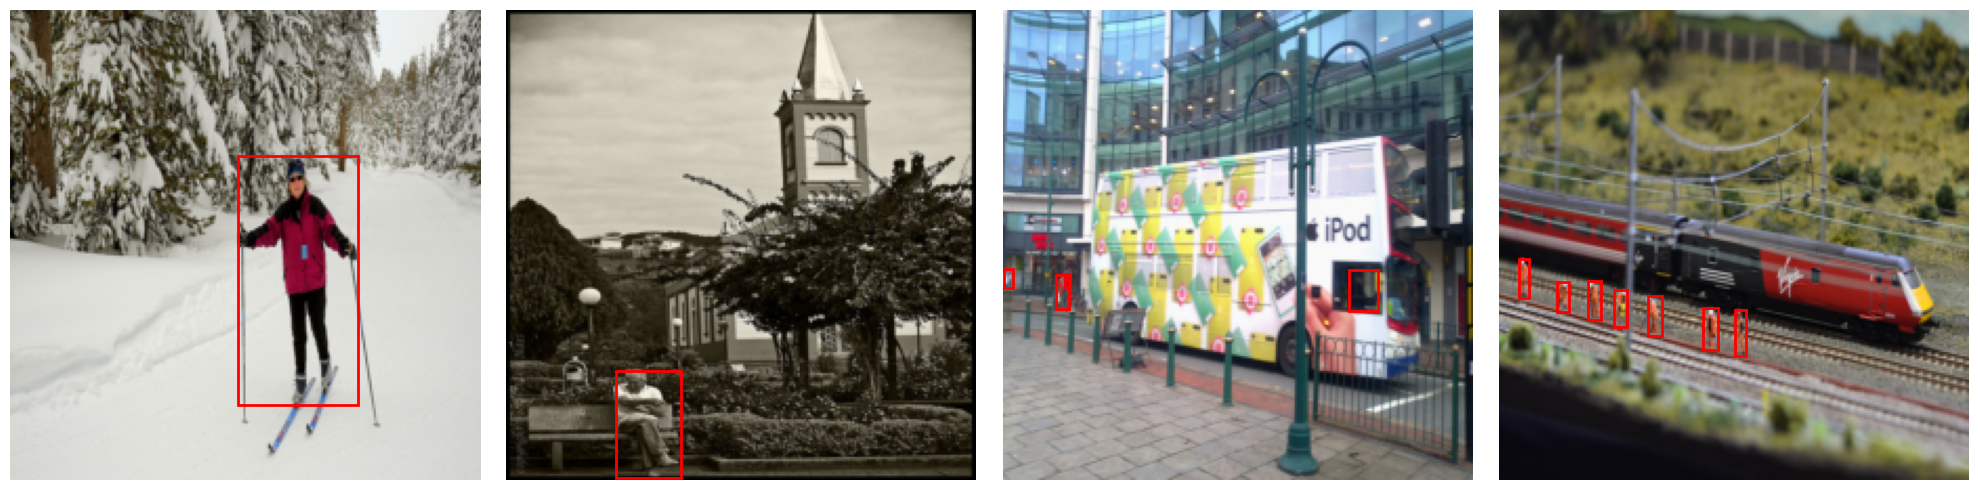

In [8]:
def visualize_sample(images, targets):
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    num_samples = len(images)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for i, (image, target) in enumerate(zip(images, targets)):

        image = image * std + mean  
        image = F.to_pil_image(image)  
        
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(image)
        ax.axis('off')

        for box in target['boxes']:
            x_min, y_min, x_max, y_max = box.numpy()
            rect = plt.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                fill=False,
                edgecolor='red',
                linewidth=2
            )
            ax.add_patch(rect)
    
    plt.tight_layout()
    plt.show()

for images, targets in train_dataloader:
    visualize_sample(images, targets)
    break

for images, targets in val_dataloader:
    visualize_sample(images, targets)
    break

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


Epoch 1/10: 100%|██████████| 750/750 [05:39<00:00,  2.21it/s, loss=0.447] 


Epoch 1/10, Average Loss: 0.4386


Epoch 2/10: 100%|██████████| 750/750 [05:39<00:00,  2.21it/s, loss=0.429] 


Epoch 2/10, Average Loss: 0.3716


Epoch 3/10: 100%|██████████| 750/750 [05:39<00:00,  2.21it/s, loss=0.146] 


Epoch 3/10, Average Loss: 0.3362


Epoch 4/10: 100%|██████████| 750/750 [05:40<00:00,  2.20it/s, loss=0.22]  


Epoch 4/10, Average Loss: 0.3076


Epoch 5/10: 100%|██████████| 750/750 [05:39<00:00,  2.21it/s, loss=0.151] 


Epoch 5/10, Average Loss: 0.2819


Epoch 6/10: 100%|██████████| 750/750 [05:39<00:00,  2.21it/s, loss=0.427] 


Epoch 6/10, Average Loss: 0.2591


Epoch 7/10: 100%|██████████| 750/750 [05:39<00:00,  2.21it/s, loss=0.223] 


Epoch 7/10, Average Loss: 0.2422


Epoch 8/10: 100%|██████████| 750/750 [05:39<00:00,  2.21it/s, loss=0.278] 


Epoch 8/10, Average Loss: 0.2265


Epoch 9/10: 100%|██████████| 750/750 [05:39<00:00,  2.21it/s, loss=0.283] 


Epoch 9/10, Average Loss: 0.2152


Epoch 10/10: 100%|██████████| 750/750 [05:39<00:00,  2.21it/s, loss=0.362] 

Epoch 10/10, Average Loss: 0.2034


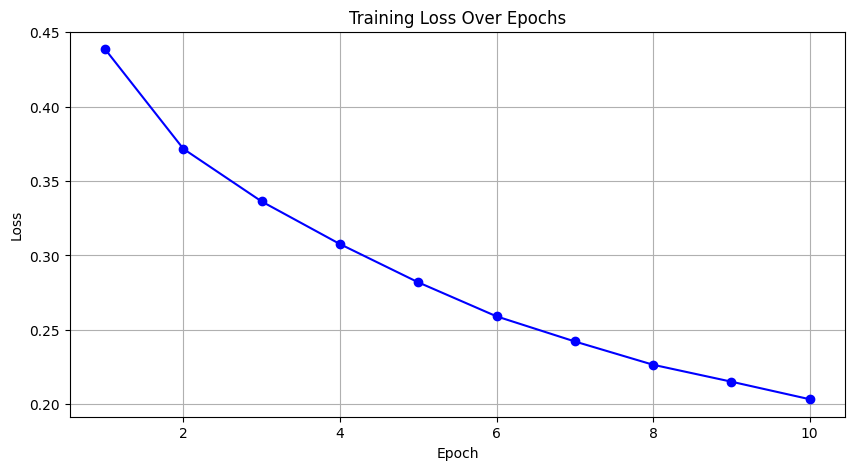

In [10]:
def train_model(model, dataloader, optimizer, num_epochs):
    """
    Melatih model menggunakan data dari dataloader.
    - Model dimasukkan ke mode pelatihan (train mode).
    - Loss dihitung untuk setiap batch dan diakumulasi untuk setiap epoch.
    - Visualisasi loss dilakukan setelah pelatihan selesai.
    """
    model.train()

    epoch_losses = []
    for epoch in range(num_epochs):
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        total_loss = 0  
        num_batches = 0
        for images, targets in loop:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            loop.set_postfix(loss=losses.item())

            total_loss += losses.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    visualize_loss(epoch_losses)


def visualize_loss(epoch_losses):
    """
    Memvisualisasikan grafik loss selama pelatihan.
    - Grafik menunjukkan tren loss dari setiap epoch.
    - Digunakan untuk memantau apakah model belajar dengan baik.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

train_model(model, train_dataloader, optimizer, num_epochs=10)

Accuracy:  0.8930895568639603


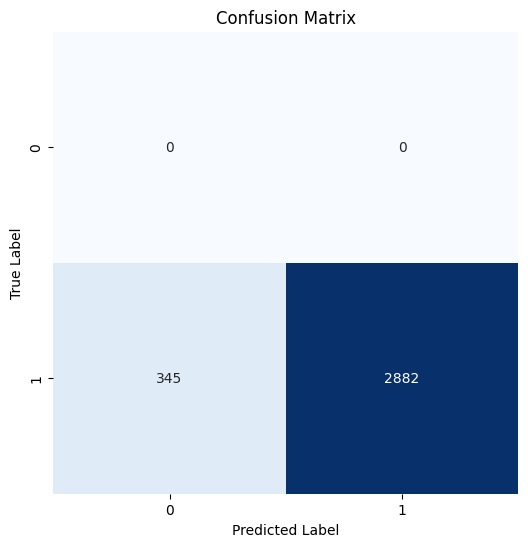

In [11]:
def evaluate_model(model, val_dataloader, device, threshold=0.5):
    """
    Mengevaluasi performa model menggunakan confusion matrix dan akurasi.
    - Prediksi difilter berdasarkan threshold.
    - Prediksi dan ground truth dipadankan untuk menghitung confusion matrix.
    - Akurasi dihitung berdasarkan keselarasan antara prediksi dan ground truth. 
    """
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)
            for pred, target in zip(predictions, targets):

                filtered_boxes = pred['boxes'][pred['scores'] > threshold].cpu().numpy()
                filtered_labels = pred['labels'][pred['scores'] > threshold].cpu().numpy()

                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()
                
                if len(filtered_labels) == 0:
                    filtered_labels = np.zeros(len(gt_labels), dtype=np.int64)
                elif len(filtered_labels) < len(gt_labels):
                    filtered_labels = np.pad(
                        filtered_labels,
                        (0, len(gt_labels) - len(filtered_labels)),
                        constant_values=0
                    )
                elif len(filtered_labels) > len(gt_labels):
                    filtered_labels = filtered_labels[:len(gt_labels)]

                all_preds.extend(filtered_labels)
                all_targets.extend(gt_labels)

    cm = confusion_matrix(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, all_preds)
    return cm, accuracy


def visualize_confusion_matrix(cm):
    """
    Memvisualisasikan confusion matrix menggunakan heatmap.
    - Digunakan untuk melihat distribusi prediksi dan kesalahan klasifikasi.
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

cm, accuracy = evaluate_model(model, val_dataloader, device)
print("Accuracy: ", accuracy)
visualize_confusion_matrix(cm)

Average IoU: 0.4439


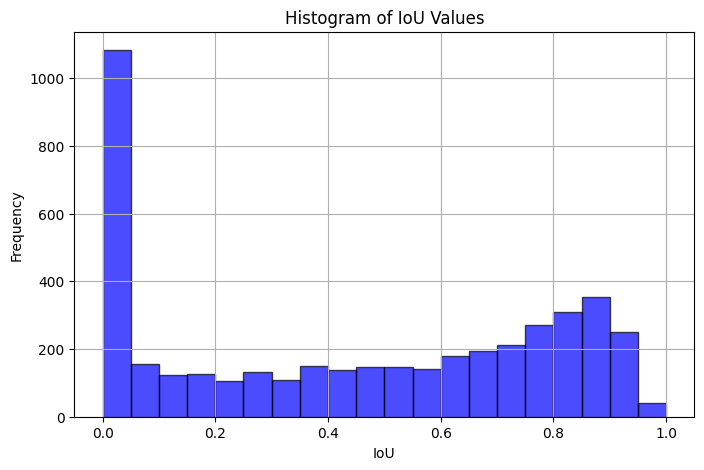

In [12]:
def calculate_iou(box1, box2):
    """
    Menghitung Intersection over Union (IoU) antara dua bounding box.
    - IoU digunakan untuk mengevaluasi keselarasan antara bounding box prediksi dan ground truth.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

def visualize_iou_histogram(ious):
    """
    Memvisualisasikan distribusi nilai IoU menggunakan histogram.
    - Digunakan untuk melihat seberapa baik model mendeteksi objek.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(ious, bins=20, range=(0, 1), color='blue', alpha=0.7, edgecolor='black')
    plt.title("Histogram of IoU Values")
    plt.xlabel("IoU")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


def evaluate_bounding_boxes(model, val_dataloader, device, threshold=0.5):
    """
    Mengevaluasi performa bounding box menggunakan IoU (Intersection over Union).
    - IoU dihitung untuk setiap pasangan bounding box prediksi dan ground truth.
    - Rata-rata IoU dihitung untuk mengevaluasi performa deteksi objek.
    """
    model.eval()
    ious = [] 
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)
            for pred, target in zip(predictions, targets):
                filtered_boxes = pred['boxes'][pred['scores'] > threshold].cpu().numpy()
                gt_boxes = target['boxes'].cpu().numpy()
                for pred_box in filtered_boxes:
                    best_iou = 0
                    for gt_box in gt_boxes:
                        iou = calculate_iou(pred_box, gt_box)
                        best_iou = max(best_iou, iou)
                    ious.append(best_iou)  
    
    avg_iou = np.mean(ious)
    print(f"Average IoU: {avg_iou:.4f}")
    
    return ious, avg_iou  

ious, avg_iou = evaluate_bounding_boxes(model, val_dataloader, device)
visualize_iou_histogram(ious)

In [13]:
def save_model(model, path):
    """
    Menyimpan state dictionary model ke file.
    - Digunakan untuk menyimpan model setelah pelatihan.
    """
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(path, num_classes):
    """
    Memuat model dari file state dictionary.
    - Model dimuat dengan konfigurasi yang sesuai (misalnya, jumlah kelas).
    - Digunakan untuk melanjutkan pelatihan atau inferensi.
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(path))
    model.to(device)
    print(f"Model loaded from {path}")
    return model

save_model(model, "faster_rcnn_person.pth")
loaded_model = load_model("faster_rcnn_person.pth", num_classes=2)

Model saved to faster_rcnn_person.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-13-5ecedec51581>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded from faster_rcnn_person.pth


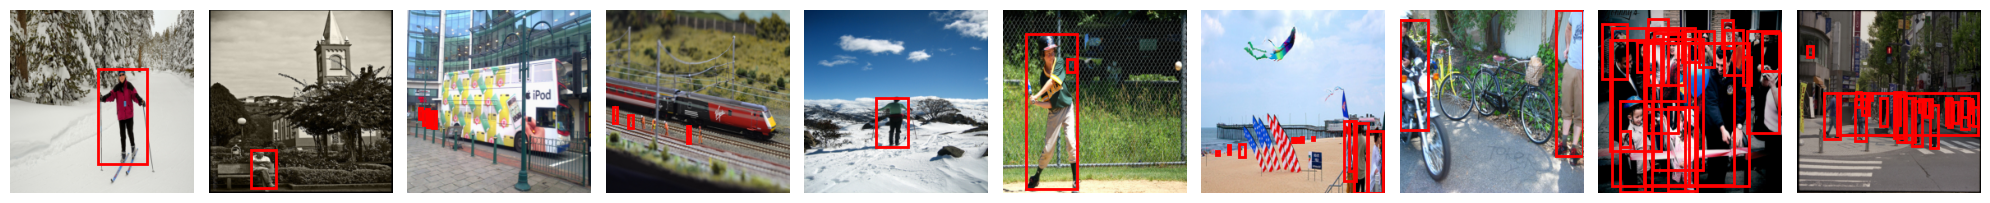

In [14]:
def predict_and_visualize(model, val_dataloader, device, threshold=0.5, max_images=4):
    """
    Melakukan prediksi pada dataset validasi dan memvisualisasikan hasilnya.
    - Model dimasukkan ke mode evaluasi (eval mode).
    - Hanya memproses hingga jumlah maksimum gambar yang ditentukan.
    - Hasil prediksi divisualisasikan dalam grid subplot.
    """
    model.eval()
    counter = 0  
    
    all_images = []
    all_predictions = []
    with torch.no_grad():
        for images, targets in val_dataloader:
            images = list(image.to(device) for image in images)
            predictions = model(images)

            all_images.extend(images)
            all_predictions.extend(predictions)
            
            counter += len(images)

            if counter >= max_images:
                break

    visualize_predictions(all_images[:max_images], all_predictions[:max_images], threshold)


def visualize_predictions(images, predictions, threshold=0.5):
    """
    Memvisualisasikan gambar dengan bounding box hasil prediksi.
    - Gambar ditampilkan dalam grid subplot.
    - Bounding box hanya ditampilkan jika skor kepercayaannya melebihi threshold.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))  
    
    for i, (image, prediction) in enumerate(zip(images, predictions)):
        ax = axes[i] if num_images > 1 else axes 
        image = image.cpu() * std + mean
        image = image.permute(1, 2, 0).numpy()
        ax.imshow(image)
        ax.axis('off')

        for box, score in zip(prediction['boxes'], prediction['scores']):
            if score > threshold:
                x_min, y_min, x_max, y_max = box.cpu().numpy()
                rect = plt.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    fill=False,
                    edgecolor='red',
                    linewidth=2
                )
                ax.add_patch(rect)
    
    plt.tight_layout()
    plt.show()
    
predict_and_visualize(loaded_model, val_dataloader, device, threshold=0.5, max_images=10)